In [2]:
# Import necessary libraries
%matplotlib inline
import operator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures


### Reading the dataset

In [3]:
# Read the file "dataset.csv" as a Pandas dataframe 
df = pd.read_csv("final-dataset.csv")
anyNan = np.any(np.isnan(df)) 
allFinite = np.all(np.isfinite(df))
df = df.astype(float)
df.describe()

,IRI0,Rainfall,Temperature min,Temperature max,Truck CV,Target IRI
count,3588.000000,3588.000000,3588.000000,3588.000000,3588.000000,3588.000000
mean,5.920852,2503.266388,5369.943423,7635.647993,1294.583333,8.274576
std,2.095145,1358.258465,2191.556325,3911.924430,1209.071785,3.213427
min,1.000000,242.400000,1941.000000,0.000000,49.000000,2.100000
25%,4.470000,1514.500000,3467.000000,5325.000000,481.000000,6.000000
50%,5.400000,2143.500000,5264.000000,5579.000000,949.000000,7.600000
75%,6.920000,3359.100000,7037.000000,10917.000000,1704.000000,9.800000
max,17.400000,11883.700000,12480.000000,17735.000000,11498.000000,26.160000


In [4]:
# Choose all the predictors as the variable 'X' (note capitalization of X for multiple features)
x = df.drop(['Target IRI'],axis=1)

# Choose the response variable 'y' 
y = df['Target IRI']
x



,IRI0,Rainfall,Temperature min,Temperature max,Truck CV
0,4.87,2075.0,3093.0,5526.0,556.0
1,4.66,1399.3,3093.0,5526.0,1231.0
2,5.61,1695.8,3093.0,5526.0,1231.0
3,3.74,1695.8,3093.0,5526.0,1231.0
4,3.29,1096.4,4007.0,5798.0,658.0
...,...,...,...,...,...
3583,7.50,2108.6,9879.0,0.0,263.0
3584,7.20,2108.6,9879.0,0.0,95.0
3585,6.60,2108.6,9879.0,0.0,95.0
3586,7.10,2871.9,9879.0,0.0,95.0


### Train-validation split

In [5]:
### edTest(test_random) ###
# Split the data into train and validation sets with 90% for training 
# and with a random_state=1
x_train, x_val, y_train, y_val = train_test_split(x, y, train_size=0.90, random_state=42)


### Computing the MSE

In [6]:
### edTest(test_regression) ###

# To iterate over the range, select the maximum degree of the polynomial
maxdeg = 5



# Create three empty lists to store training, validation and cross-validation MSEs
training_error, validation_error,cross_validation_training_error, cross_validation_error, r2, r2_calc, cross_validation_r2 = [],[],[],[],[],[],[]

# Loop through the degrees of the polynomial
for d in range(1,maxdeg+1):
    
    # Compute the polynomial features for the entire data
    x_poly = PolynomialFeatures(degree=d).fit_transform(x)

    # Compute the polynomial features for the train data
    x_poly_train = PolynomialFeatures(degree=d).fit_transform(x_train)

    # Compute the polynomial features for the validation data
    x_poly_val = PolynomialFeatures(degree=d).fit_transform(x_val)

    # Initialize a Linear Regression object (set fit_intercept to False since PolynomialFeatures adds an intercept by default)
    lreg = LinearRegression(fit_intercept=False)
  
    # Fit model on the training set
    lreg.fit(x_poly_train, y_train)

    # Predict on the training data
    y_train_pred = lreg.predict(x_poly_train)

    # Predict on the validation set
    y_val_pred = lreg.predict(x_poly_val)
    
    # Compute the mse on the train data
    training_error.append(mean_squared_error(y_train, y_train_pred))

    # Compute the mse on the validation data
    validation_error.append(mean_squared_error(y_val, y_val_pred))


    # Get the r2
    r2.append(lreg.score(x_poly_val, y_val))
    r2_calc.append(1- (mean_squared_error(y_val, y_val_pred)/ np.var(y)))
    
    # Perform cross-validation on the entire data with 10 folds and 
    # get the mse_scores
    nlreg = LinearRegression(fit_intercept=False)

    mse_score = cross_validate(nlreg, x_poly, y, scoring="neg_mean_squared_error", cv=10, return_train_score=True)

    # Compute the mean of the cross validation error and store in list 
    # Remember to take into account the sign of the MSE metric returned by the cross_validate function 
    cross_validation_error.append(np.mean(-mse_score['test_score']))
    cross_validation_training_error.append(np.mean(-mse_score['train_score']))
    cross_validation_r2.append(1- (np.mean(-mse_score['test_score'])/ np.var(y)))
    print(cross_validation_training_error)
    print(training_error)
    

[2.405395914754668]
[2.4310719399285317]
[2.405395914754668, 2.1909481171608483]
[2.4310719399285317, 2.2130002155363875]
[2.405395914754668, 2.1909481171608483, 2.076163058336302]
[2.4310719399285317, 2.2130002155363875, 2.0987688388495425]
[2.405395914754668, 2.1909481171608483, 2.076163058336302, 1.86000274405782]
[2.4310719399285317, 2.2130002155363875, 2.0987688388495425, 1.8429728991124046]
[2.405395914754668, 2.1909481171608483, 2.076163058336302, 1.86000274405782, 2.0618612131447156]
[2.4310719399285317, 2.2130002155363875, 2.0987688388495425, 1.8429728991124046, 1.809162664146403]


### Finding the best degree

In [7]:
### edTest(test_best_degree) ###

# Get the best degree associated with the lowest validation error
min_mse = min(validation_error)
best_degree = validation_error.index(min_mse)+1


# Get the best degree associated with the lowest cross-validation error
min_cross_val_mse = min(cross_validation_error)
best_cross_val_degree = cross_validation_error.index(min_cross_val_mse)+1

max_r2 = max(r2)
max_r2_deg = r2.index(max_r2)
max_r2_calc = max(r2_calc)
max_r2_calc_deg = r2_calc.index(max_r2_calc)
max_cross_validation_r2 = max(cross_validation_r2)
max_cross_validation_r2_deg = cross_validation_r2.index(max_cross_validation_r2)

# Print the values
print("The best degree of the model using validation is",best_degree)
print("The best degree of the model using cross-validation is",best_cross_val_degree)
print("Max corss val r2 = ",max_cross_validation_r2)
print(f"Validation error list: {validation_error}")
print(f"Cross-validation error list: {cross_validation_error}")
print(f"The r2 list is: {r2}")
print(f"The r2_calc list is: {r2}")
print(f"The cross_validation_r2 list is: {cross_validation_r2}")

The best degree of the model using validation is 2
The best degree of the model using cross-validation is 2
Max corss val r2 =  0.7657837297694214
Validation error list: [2.226020416766271, 2.101878046805288, 2.1780058320865927, 2.7449753117859976, 7.820521747413917]
Cross-validation error list: [2.512389381912262, 2.417870073379034, 12.363206895183136, 138.63155620130192, 8238.64523691612]
The r2 list is: [0.7746114962407761, 0.7871811307364367, 0.7794730578500331, 0.7220663953845414, 0.20815834302782577]
The r2_calc list is: [0.7746114962407761, 0.7871811307364367, 0.7794730578500331, 0.7220663953845414, 0.20815834302782577]
The cross_validation_r2 list is: [0.7566277539570042, 0.7657837297694214, -0.19760951548236072, -12.429078091178178, -797.0680105141942]


### Plotting the error graph

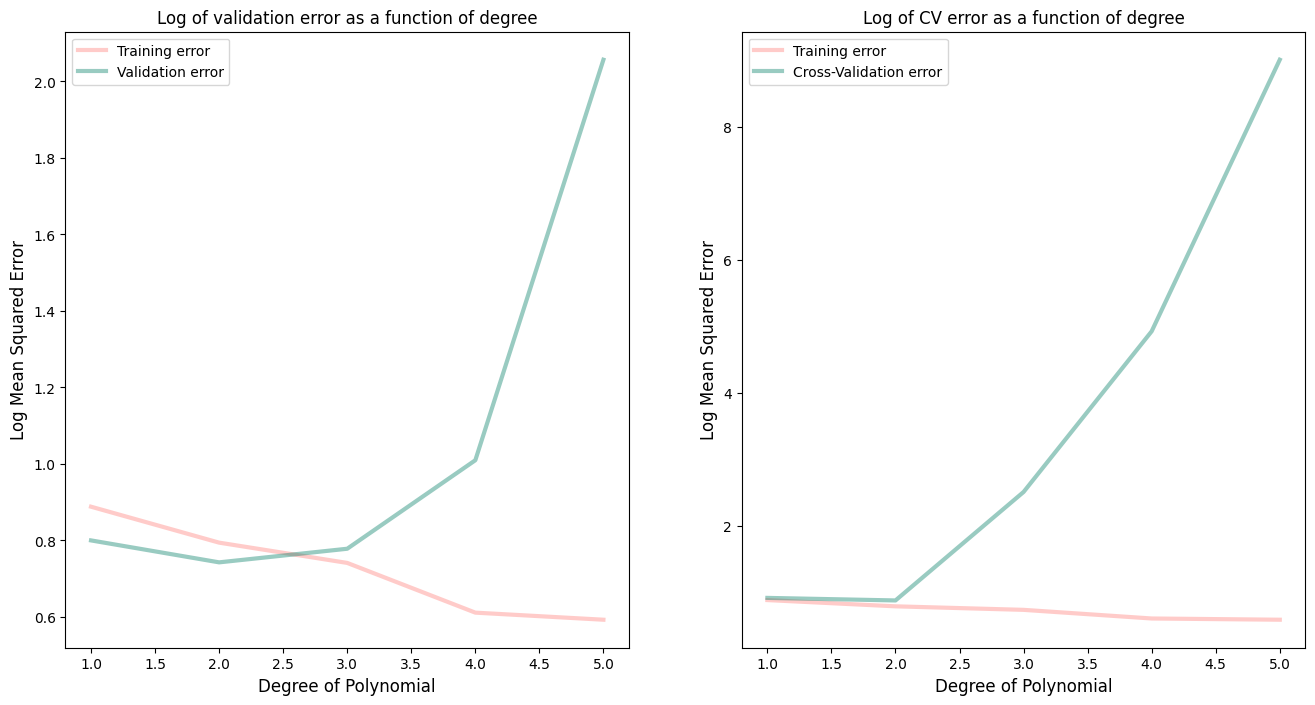

In [8]:
# Plot the errors as a function of increasing d value to visualise the training and validation errors
fig, ax = plt.subplots(1,2, figsize=(16,8))

# Plot the training error with labels
ax[0].plot(range(1,maxdeg+1), np.log(training_error), label = 'Training error', linewidth=3, color='#FF7E79', alpha=0.4)

# Plot the validation error with labels
ax[0].plot(range(1,maxdeg+1), np.log(validation_error), label = 'Validation error', linewidth=3, color="#007D66", alpha=0.4)

# Plot the training error with labels
ax[1].plot(range(1,maxdeg+1), np.log(training_error), label = 'Training error', linewidth=3, color='#FF7E79', alpha=0.4)

# Plot the cross-validation error with labels
ax[1].plot(range(1,maxdeg+1), np.log(cross_validation_error), label = 'Cross-Validation error', linewidth=3, color="#007D66", alpha=0.4)

# Set the plot labels and legends
ax[0].set_xlabel('Degree of Polynomial', fontsize=12)
ax[0].set_ylabel('Log Mean Squared Error', fontsize=12)
ax[0].set_title("Log of validation error as a function of degree")

ax[1].set_xlabel('Degree of Polynomial', fontsize=12)
ax[1].set_ylabel('Log Mean Squared Error', fontsize=12)
ax[1].set_title("Log of CV error as a function of degree")

ax[0].legend()
ax[1].legend()
plt.show();


⏸ If you run the exercise with a random state of 0, do you notice any change? What conclusion can you draw from this experiment?


In [9]:
### edTest(test_chow1) ###
# Submit an answer choice as a string below 
answer1 = 'When the random_state is changed to zero, it can be seen that the plot of log of validation error as a function of degree changes considerably while the plot of log of CV error as a function of degree remains almost the same. Since we pass our entire data to the cross validation, it splits the data into k-folds and perfroms training in k-1 folds and validation on the remaining 1 fold. This is repeated for k-1 times with the validaiton set being different each time. This results in the average MSE being almost the same for each degree. The validation error changes for each degree because it is working on different subset of data.'


In [10]:


from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
### edTest(test_knn_mse) ###

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.90, random_state=42)


# Initialize a list of k values to specify the number of neighbors
knn_list = range(1,20)
test_error=[]
r2_calc_list=[]
r2_calc, max_r2 = 0, 0
k_at_max_r2 = 0

# Loop through the k values from the list defined above
for i in knn_list:
    
    # Initialize a kNN model with the current k value
    model = KNeighborsRegressor(i)
    
    # Fit the model on the train data
    model.fit(x_train, y_train)
    
    # Predict using the trained model on the test data
    y_pred = model.predict(x_test)
    
    # Compute the MSE of the test predictions
    mse = mean_squared_error(y_test, y_pred)

    r2_calc = 1- mse/ np.var(y)

    if r2_calc > max_r2:
        max_r2 = r2_calc
        k_at_max_r2 = i


    r2_calc_list.append(r2_calc)
    
    # Append the error to the list initialized above
    test_error.append(mse)

print(test_error)
print(r2_calc_list)
print(f"min mse:{min(test_error)}")
print(f"max r2:{max(r2_calc_list)}")
print(f"max r2:{max_r2} at k = {k_at_max_r2}")

[2.667613091922006, 2.3160593314763234, 2.1038042092231506, 2.085187047353761, 2.211306440111421, 2.2941506731662025, 2.4157672673526234, 2.475878225104457, 2.6212529179132704, 2.752406245125348, 2.8719059301549303, 2.9563507099195294, 3.0579709103195927, 3.159530113410266, 3.302393771587744, 3.4454105882224932, 3.5668911287602048, 3.689617932184737, 3.816420238582088]
[0.7415914131667702, 0.7756460182771476, 0.796206925837411, 0.7980103487191185, 0.7857933093915408, 0.7777682846022282, 0.7659874261507725, 0.7601645473784047, 0.7460822694634412, 0.733377598742647, 0.7218018028264328, 0.7136217349333444, 0.7037779039600265, 0.6939399817253364, 0.6801009448232987, 0.6662470716391087, 0.6544793925468346, 0.6425909894138888, 0.6303077970339455]
min mse:2.085187047353761
max r2:0.7980103487191185
max r2:0.7980103487191185 at k = 4
